In [1]:
import sys, os
import argparse
import time
from types import SimpleNamespace

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import faiss
import skimage.io as io

from dataset import CocoDataset, EmbedDataset
from utils import weight_init, collater, sec2str
from model import ImageEncoder, CaptionEncoder
from vocab import Vocabulary
from eval import retrieve_i2c, retrieve_c2i

In [2]:
path = "models/vsepp_fine"
sorted(os.listdir(path))

['epoch_0031_score_401.ckpt',
 'epoch_0032_score_414.ckpt',
 'epoch_0033_score_421.ckpt',
 'epoch_0034_score_427.ckpt',
 'epoch_0035_score_430.ckpt',
 'epoch_0036_score_436.ckpt',
 'epoch_0037_score_439.ckpt',
 'epoch_0038_score_441.ckpt',
 'epoch_0039_score_444.ckpt',
 'epoch_0040_score_447.ckpt',
 'epoch_0041_score_449.ckpt',
 'epoch_0042_score_452.ckpt',
 'epoch_0044_score_454.ckpt',
 'epoch_0045_score_456.ckpt']

In [3]:
def get_args():
    a = {
        "dataset": "coco",
        "checkpoint": os.path.join(path, "epoch_0045_score_456.ckpt"),   # checkpoint from where to load model
        'root_path': '/groups1/gaa50131/datasets/MSCOCO',
        'vocab_path': 'captions_train2017.txt',
        'cnn_type': "resnet152",
        'rnn_type': "GRU",
        'emb_size': 300,
        'out_size': 1024,
        'max_len': 30,
        'n_cpu': 8,
        'imsize_pre': 224, 
        'imsize': 224, 
        'batch_size': 128
    }
    
    args = SimpleNamespace(**a)
    
    return args

args = get_args()

In [4]:
# transform if dataset is of images
transform = transforms.Compose([
    transforms.Resize((args.imsize_pre, args.imsize_pre)),
    transforms.CenterCrop(args.imsize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

if args.dataset == 'coco':
    val_dset = CocoDataset(root=args.root_path, imgdir='val2017', jsonfile='annotations/captions_val2017.json', transform=transform)
val_loader = DataLoader(val_dset, batch_size=args.batch_size, shuffle=False, num_workers=args.n_cpu, collate_fn=collater)
vocab = Vocabulary(max_len=args.max_len)
vocab.load_vocab(args.vocab_path)

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
building vocabulary...
done building vocabulary, minimum frequency is 5 times
# of words in vocab: 10210 | elapsed: 36s


In [5]:
imenc = ImageEncoder(out_size=args.out_size, cnn_type=args.cnn_type)
capenc = CaptionEncoder(vocab_size=len(vocab), emb_size=args.emb_size, out_size=args.out_size, rnn_type=args.rnn_type, padidx=vocab.padidx)
device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")

assert args.checkpoint is not None
print("loading model checkpoint from {}".format(args.checkpoint))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = torch.load(args.checkpoint, map_location=device)
imenc.load_state_dict(ckpt["encoder_state"])
capenc.load_state_dict(ckpt["decoder_state"])

begin = time.time()
print("creating database")
dset = EmbedDataset(val_loader, imenc, capenc, vocab, args)
print("database created | {}".format(sec2str(time.time()-begin)))

loading model checkpoint from models/vsepp_fine/epoch_0045_score_456.ckpt
creating database
database created | elapsed: 04m11s


--------------------------------------------------


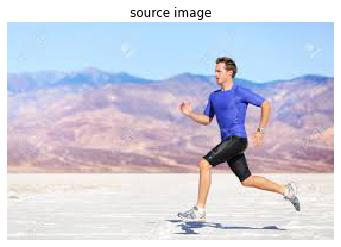

# captions: 25000, dimension: 1024
retrieval time elapsed: 00s
--------------------------------------------------
20 nearest neighbors of image:
There is a person in the picture by itself.

Individual is doing something at the moment that is intriguing.
Individual is doing something at the moment that is intriguing.

An individual is capture in the stillness of the picture.

a person standing next to a person getting ready to catch a ball
A photo of a person being taken in this picture.

Man preforming a trick with a disk toy.
A being is doing something as of right now that is splendid. 

A pavement where a person foot are seen having skates. 
A woman attending an exposition about the future.
There is no image to be reviewed on this hit.
There is no image here to provide a caption for.
There is no image here to provide a caption for.
There is no image here to provide a caption for.
There is no image here to provide a caption for.
A man seems to be disguised as Marty McFly here, from Ba

In [6]:
%matplotlib inline
retrieve_i2c(dset, val_dset, "samples/sample1.jpg", imenc, transform, k=20)

--------------------------------------------------
source caption: 'a dog barking at a car.'
# images: 5000, dimension: 1024
retrieval time elapsed: 00s
--------------------------------------------------
5 nearest neighbors of 'a dog barking at a car.'


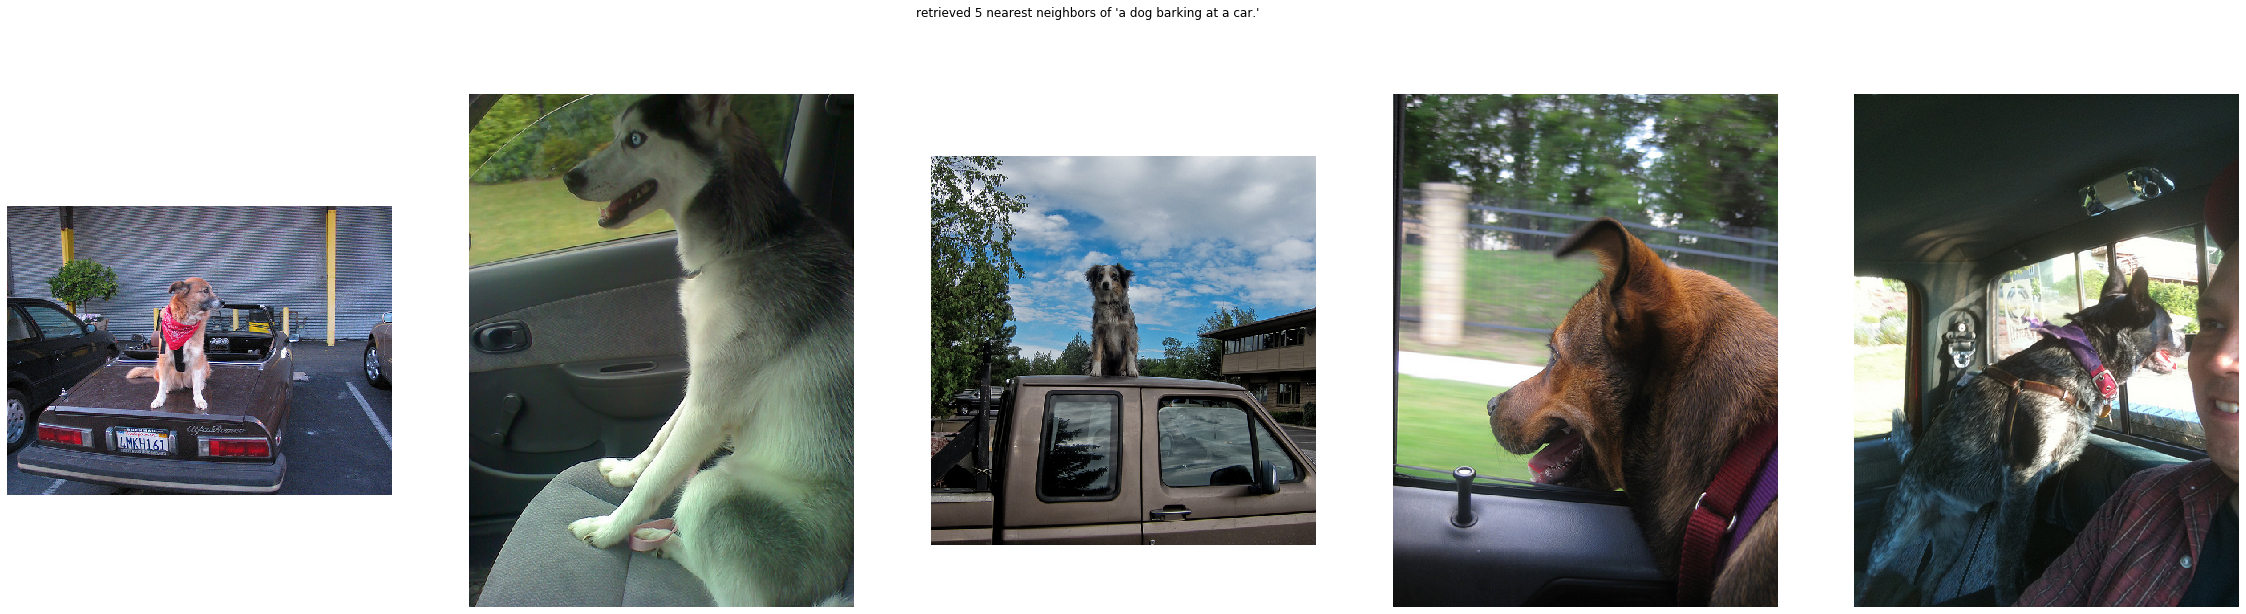

--------------------------------------------------


In [7]:
%matplotlib inline
caption = "a dog barking at a car."
retrieve_c2i(dset, val_dset, caption, capenc, vocab, k=5)